# <span style='background-color: #fff5b1'>오늘의 한 걸음  🚶🏽‍♂️: Transformer 로 chatbot 만들기</span>

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
    2-3. 모델 학습  
    2-4. 데이터 평가   

### 3. POTG (best Play Of The Game
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric


지금까지 배운 내용을 바탕으로  

한국어 데이터를 이용해 chatbot 을 만든다!  

한국어 대화 데이터는 [여기](https://github.com/songys/Chatbot_data)에서 제공한다.  
송영숙님께서 깃을 통해 다음카페 텍스트 데이터를 제공하고 있다.

해당 데이터는 

질문과 대답 쌍으로 이루어져 있다. 

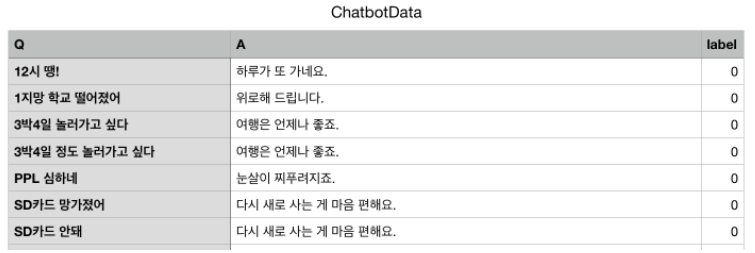

이 데이터를 이용해 

1. 전처리(Tokenize, Lexcical Substitution, Vectorize)
2. transformer 생성
3. 훈련
4. 성능 측정 (BLEU)

과정을 진행해보도록 한다.

솔직히 이 과제를 따라올 수 있다면 NLP 는 80%를 알고 있다고 해도  
과언이 아니다. 하나하나 천천히 해보도록 하겠다.



## 1-2. 사용하는 라이브러리

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


# 2. GAME
## 2-1. 데이터 읽어오기

In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/goingDeeper/data/ChatbotData .csv' 
df = pd.read_csv(dataset_filepath) 
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
df.columns

Index(['Q', 'A', 'label'], dtype='object')

Q, A, label 로 구성되어있는 dataframe



## 2-2.데이터 전처리

In [4]:
df.count()

Q        11823
A        11823
label    11823
dtype: int64

In [5]:
# 중복값 먼저 제거

df.drop_duplicates(['Q'])
df.drop_duplicates(['A'])


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
...,...,...,...
11817,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.,2
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2


In [6]:
df.count()

Q        11823
A        11823
label    11823
dtype: int64

### 2-2-1. 데이터 정제 함수 구현

In [9]:
def preprocess_sentence(sentence):
    sentence = sentence.strip()

    #소문자 변환
    sentence = sentence.lower()
    
    #한국어,영어,숫자, 특수문자 가 아닌 경우 공백으로 교체
    sentence = re.sub(r"[^0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]", " ", sentence)
    
    # 주요 특수문자 좌우에 공백
    #sentence = re.sub(r"([?.!,])", r"  ", sentence) 
    #영문자의 경우, 좌우에 공백
    #sentence = re.sub(r"([a-zA-Z]+)", r" \1 ", sentence) 

    #긴 공백을 한 칸의 공백으로 교체
    sentence = re.sub(r'[" "]+', " ", sentence)
 
    #문장의 양끝 공백 제거
    sentence = sentence.strip() 
    
    return sentence

### 2-2-2. Tokenize

한국어 형태소 분석기인 Mecab 클래스를 활용해  
형태소 기반 토큰화를 진행한다.

In [18]:
import konlpy

print(konlpy.__version__)


0.5.2


In [22]:
mecab_corpus[:5]

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네']]

In [26]:
max([len(sentence) for sentence in mecab_corpus]) #가장 긴 단어

40

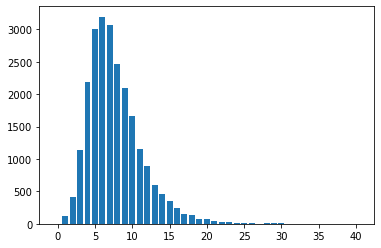

In [37]:
import matplotlib.pyplot as plt
import numpy as np

length_distribution = [0]*41
for sentence in mecab_corpus:
    length_distribution[len(sentence)] += 1 # N 길이의 문장 갯수 확인

    
x = np.arange(41)
plt.bar(x,length_distribution)

plt.show()

데이터 토큰 이후 길이 분포를 봤을 때 10 문장 이내의 값만 사용하는 것이 합리적.

In [14]:
from konlpy.tag import Mecab

mecab = Mecab()


def build_corpus(Q,A): #df['Q'], df['A']
    Q = list(map(preprocess_sentence, Q))
    A = list(map(preprocess_sentence, A)) #데이터 정제

    def mecab_split(sentence):
        return mecab.morphs(sentence) #형태소 별 토큰화

    que_corpus = []
    ans_corpus = []
    for sentence in zip(Q,A): # 토큰이 10개 이하인 문장만 담기
        if len(mecab_split(sentence[0]))<= 10  and len(mecab_split(sentence[1])) <= 10:
            que_corpus.append(mecab_split(sentence[0]))
            ans_corpus.append(['<sos>']+ mecab_split(sentence[1]) + ['<eos>'])
    
    return que_corpus, ans_corpus
            

In [15]:
que_corpus, ans_corpus = build_corpus(df['Q'], df['A'])

In [19]:


cnt = 0
for a, b in zip(que_corpus,ans_corpus):
    print(f'질문 : {a}')
    print(f'대답 : {b}')
    print()
    cnt += 5
    if cnt > 5:
          break

질문 : ['12', '시', '땡', '!']
대답 : ['<sos>', '하루', '가', '또', '가', '네요', '.', '<eos>']

질문 : ['1', '지망', '학교', '떨어졌', '어']
대답 : ['<sos>', '위로', '해', '드립니다', '.', '<eos>']



## 2-3.모델 학습

## 2-4.데이터 평가

# 3. POTG
## 3-1. 소감

## 3-2. 어려웠던 점과 극복방안

### 1. 예전과 달리 더 쉬워진 전처리
예전에는 영문자나 특수문자 간에 공백을 줘서 단어사전을 만들 때  
확실히 나누어질 수 있는 코드가 있었다.  
`    #sentence = re.sub(r"([?.!,])", r"  ", sentence) `  
허나 사실 실무적으로는 tokenizer 과정에서 지원이 되기 때문에  
따로 코드를 작성할 필요가 없다는 것을 알았다.

## 3-3. 추후